In [1]:
import numpy as np
import pandas as pd
from numpy import pi
import qiskit
from qiskit import execute, Aer
from qiskit.visualization import plot_histogram
from qiskit.tools.visualization import plot_state_city, plot_bloch_multivector
from qiskit.tools.monitor import job_monitor
from qiskit.quantum_info import state_fidelity
from qiskit.quantum_info import DensityMatrix
from qiskit.quantum_info.random.utils import random_state
import random
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, Aer
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

# Tomography functions
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
import qiskit.ignis.mitigation.measurement as mc
# imports IBMQ backends
from qiskit.providers.ibmq import IBMQ
from qiskit.providers.aqt import AQT
aqt_provider_simulators = AQT.enable_account('2633b2d14dae4d9da7c9df2503857334')
ibmq_provider = IBMQ.load_account()        # credentials stored on disk
simulator = ibmq_provider.get_backend('ibmq_qasm_simulator')
device = ibmq_provider.get_backend('ibmq_16_melbourne') #ibmq_burlington
aqt_device = aqt_provider_simulators.get_backend('aqt_qasm_simulator_noise_1')

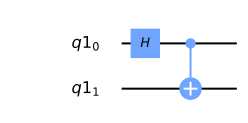

In [2]:
qreg = QuantumRegister(4)
qreg_exp = QuantumRegister(2)
qc_expected = QuantumCircuit(qreg_exp)
qc_expected.h(0)
qc_expected.cx(0,1)
qc_expected.draw(output='mpl')

The expected state is: [0.70710678+0.j 0.        +0.j 0.        +0.j 0.70710678+0.j]


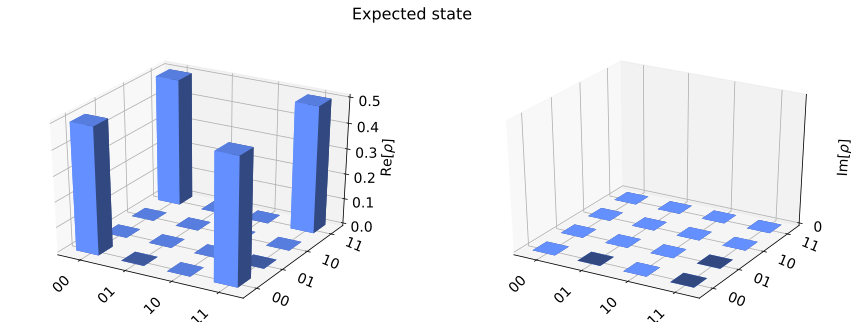

In [3]:
job = qiskit.execute(qc_expected, Aer.get_backend('statevector_simulator'))
psi_expected = job.result().get_statevector(qc_expected)
print('The expected state is:', psi_expected)
plot_state_city(psi_expected, title='Expected state')

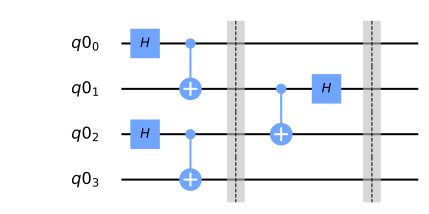

In [4]:
qc1 = QuantumCircuit(qreg)
qc1.h(0)
qc1.h(2)
qc1.cx(0,1)
qc1.cx(2,3)
qc1.barrier()
qc1.cx(1,2)
qc1.h(1)
qc1.barrier()
qc1.draw(output='mpl')

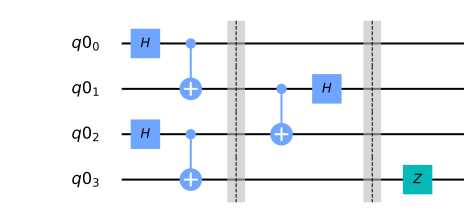

In [5]:
qc2 = QuantumCircuit(qreg)
qc3 = QuantumCircuit(qreg)
qc4 = QuantumCircuit(qreg)
qcs = [qc1, qc2, qc3, qc4]
for qc in range(3):
    q2 = QuantumCircuit(qreg)
    if qc == 0 or qc == 2:
        q2.z(3)
    if qc == 1 or qc == 2:
        q2.x(3)
    qcs[qc+1]= qcs[0] +q2
qcs[1].draw(output='mpl')

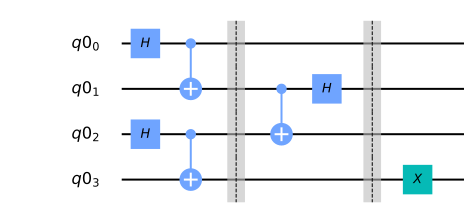

In [6]:
qcs[2].draw(output='mpl')

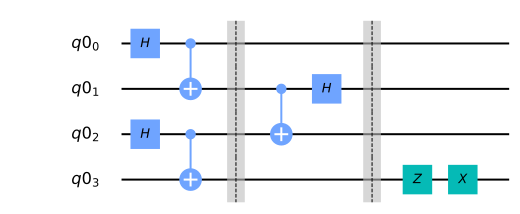

In [7]:
qcs[3].draw(output='mpl')

In [8]:
backends = [simulator,device]
bits = [ '1000', '0000', '1110', '1010', '0110', '0010', '1100', '0100','1001', '0001', '1111', '1011', '0111', '0011', '1101', '0101']
paulis = [('X','Z','Z','X'),('X','Z','Z','Y'),('X','Z','Z','Z'),
          ('Y','Z','Z','X'),('Y','Z','Z','Y'),('Y','Z','Z','Z'),
          ('Z','Z','Z','X'),('Z','Z','Z','Y'),('Z','Z','Z','Z')]
for be in backends:
    state = {'XX': {'00': 0, '10': 0,'01': 0, '11': 0}, 
             'YX': {'00': 0, '10': 0,'01': 0, '11': 0}, 
             'ZX': {'00': 0, '10': 0,'01': 0, '11': 0}, 
             'XY': {'00': 0, '10': 0,'01': 0, '11': 0}, 
             'YY': {'00': 0, '10': 0,'01': 0, '11': 0}, 
             'ZY': {'00': 0, '10': 0,'01': 0, '11': 0}, 
             'XZ': {'00': 0, '10': 0,'01': 0, '11': 0}, 
             'YZ': {'00': 0, '10': 0,'01': 0, '11': 0}, 
             'ZZ': {'00': 0, '10': 0,'01': 0, '11': 0}}
    for qc in qcs:
        qst_circuit = state_tomography_circuits(qc,qreg)
        job = qiskit.execute(qst_circuit, be, shots=200)
        print('Done job.')
        if be == device:
            job_monitor(job)
            print(job.error_message())
        tom = StateTomographyFitter(job.result(), qst_circuit)
        if qc == qc1:
            for pauli in paulis:
                for bit in bits:
                    if bit not in tom.data[pauli]:
                        tom.data[pauli][bit]=0
            state.update({'XX': {'00': state['XX']['00']+tom.data[('X','Z','Z','X')]['0000'],
                                '10': state['XX']['10']+tom.data[('X','Z','Z','X')]['1000'],
                                '01': state['XX']['01']+tom.data[('X','Z','Z','X')]['0001'],
                                '11': state['XX']['11']+tom.data[('X','Z','Z','X')]['1001']}})
            state.update({'YX': {'00': state['YX']['00']+tom.data[('Y','Z','Z','X')]['0000'],
                                '10': state['YX']['10']+tom.data[('Y','Z','Z','X')]['1000'],
                                '01': state['YX']['01']+tom.data[('Y','Z','Z','X')]['0001'],
                                '11': state['YX']['11']+tom.data[('Y','Z','Z','X')]['1001']}})
            state.update({'ZX': {'00': state['ZX']['00']+tom.data[('Z','Z','Z','X')]['0000'],
                                '10': state['ZX']['10']+tom.data[('Z','Z','Z','X')]['1000'],
                                '01': state['ZX']['01']+tom.data[('Z','Z','Z','X')]['0001'],
                                '11': state['ZX']['11']+tom.data[('Z','Z','Z','X')]['1001']}})
            state.update({'XY': {'00': state['XY']['00']+tom.data[('X','Z','Z','Y')]['0000'],
                                '10': state['XY']['10']+tom.data[('X','Z','Z','Y')]['1000'],
                                '01': state['XY']['01']+tom.data[('X','Z','Z','Y')]['0001'],
                                '11': state['XY']['11']+tom.data[('X','Z','Z','Y')]['1001']}})
            state.update({'YY': {'00': state['YY']['00']+tom.data[('Y','Z','Z','Y')]['0000'],
                                '10': state['YY']['10']+tom.data[('Y','Z','Z','Y')]['1000'],
                                '01': state['YY']['01']+tom.data[('Y','Z','Z','Y')]['0001'],
                                '11': state['YY']['11']+tom.data[('Y','Z','Z','Y')]['1001']}})
            state.update({'ZY': {'00': state['ZY']['00']+tom.data[('Z','Z','Z','Y')]['0000'],
                                '10': state['ZY']['10']+tom.data[('Z','Z','Z','Y')]['1000'],
                                '01': state['ZY']['01']+tom.data[('Z','Z','Z','Y')]['0001'],
                                '11': state['ZY']['11']+tom.data[('Z','Z','Z','Y')]['1001']}})
            state.update({'XZ': {'00': state['XZ']['00']+tom.data[('X','Z','Z','Z')]['0000'],
                                '10': state['XZ']['10']+tom.data[('X','Z','Z','Z')]['1000'],
                                '01': state['XZ']['01']+tom.data[('X','Z','Z','Z')]['0001'],
                                '11': state['XZ']['11']+tom.data[('X','Z','Z','Z')]['1001']}})
            state.update({'YZ': {'00': state['YZ']['00']+tom.data[('Y','Z','Z','Z')]['0000'],
                                '10': state['YZ']['10']+tom.data[('Y','Z','Z','Z')]['1000'],
                                '01': state['YZ']['01']+tom.data[('Y','Z','Z','Z')]['0001'],
                                '11': state['YZ']['11']+tom.data[('Y','Z','Z','Z')]['1001']}})
            state.update({'ZZ': {'00': state['ZZ']['00']+tom.data[('Z','Z','Z','Z')]['0000'],
                                '10': state['ZZ']['10']+tom.data[('Z','Z','Z','Z')]['1000'],
                                '01': state['ZZ']['01']+tom.data[('Z','Z','Z','Z')]['0001'],
                                '11': state['ZZ']['11']+tom.data[('Z','Z','Z','Z')]['1001']}})
            print(state)
        if qc == qcs[1]:
            for pauli in paulis:
                for bit in bits:
                    if bit not in tom.data[pauli]:
                        tom.data[pauli][bit]=0
            state.update({'XX': {'00': state['XX']['00']+tom.data[('X','Z','Z','X')]['0010'],
                                '10': state['XX']['10']+tom.data[('X','Z','Z','X')]['1010'],
                                '01': state['XX']['01']+tom.data[('X','Z','Z','X')]['0011'],
                                '11': state['XX']['11']+tom.data[('X','Z','Z','X')]['1011']}})
            state.update({'YX': {'00': state['YX']['00']+tom.data[('Y','Z','Z','X')]['0010'],
                                '10': state['YX']['10']+tom.data[('Y','Z','Z','X')]['1010'],
                                '01': state['YX']['01']+tom.data[('Y','Z','Z','X')]['0011'],
                                '11': state['YX']['11']+tom.data[('Y','Z','Z','X')]['1011']}})
            state.update({'ZX': {'00': state['ZX']['00']+tom.data[('Z','Z','Z','X')]['0010'],
                                '10': state['ZX']['10']+tom.data[('Z','Z','Z','X')]['1010'],
                                '01': state['ZX']['01']+tom.data[('Z','Z','Z','X')]['0011'],
                                '11': state['ZX']['11']+tom.data[('Z','Z','Z','X')]['1011']}})
            state.update({'XY': {'00': state['XY']['00']+tom.data[('X','Z','Z','Y')]['0010'],
                                '10': state['XY']['10']+tom.data[('X','Z','Z','Y')]['1010'],
                                '01': state['XY']['01']+tom.data[('X','Z','Z','Y')]['0011'],
                                '11': state['XY']['11']+tom.data[('X','Z','Z','Y')]['1011']}})
            state.update({'YY': {'00': state['YY']['00']+tom.data[('Y','Z','Z','Y')]['0010'],
                                '10': state['YY']['10']+tom.data[('Y','Z','Z','Y')]['1010'],
                                '01': state['YY']['01']+tom.data[('Y','Z','Z','Y')]['0011'],
                                '11': state['YY']['11']+tom.data[('Y','Z','Z','Y')]['1011']}})
            state.update({'ZY': {'00': state['ZY']['00']+tom.data[('Z','Z','Z','Y')]['0010'],
                                '10': state['ZY']['10']+tom.data[('Z','Z','Z','Y')]['1010'],
                                '01': state['ZY']['01']+tom.data[('Z','Z','Z','Y')]['0011'],
                                '11': state['ZY']['11']+tom.data[('Z','Z','Z','Y')]['1011']}})
            state.update({'XZ': {'00': state['XZ']['00']+tom.data[('X','Z','Z','Z')]['0010'],
                                '10': state['XZ']['10']+tom.data[('X','Z','Z','Z')]['1010'],
                                '01': state['XZ']['01']+tom.data[('X','Z','Z','Z')]['0011'],
                                '11': state['XZ']['11']+tom.data[('X','Z','Z','Z')]['1011']}})
            state.update({'YZ': {'00': state['YZ']['00']+tom.data[('Y','Z','Z','Z')]['0010'],
                                '10': state['YZ']['10']+tom.data[('Y','Z','Z','Z')]['1010'],
                                '01': state['YZ']['01']+tom.data[('Y','Z','Z','Z')]['0011'],
                                '11': state['YZ']['11']+tom.data[('Y','Z','Z','Z')]['1011']}})
            state.update({'ZZ': {'00': state['ZZ']['00']+tom.data[('Z','Z','Z','Z')]['0010'],
                                '10': state['ZZ']['10']+tom.data[('Z','Z','Z','Z')]['1010'],
                                '01': state['ZZ']['01']+tom.data[('Z','Z','Z','Z')]['0011'],
                                '11': state['ZZ']['11']+tom.data[('Z','Z','Z','Z')]['1011']}})
            print(state)
        if qc == qcs[2]:
            for pauli in paulis:
                for bit in bits:
                    if bit not in tom.data[pauli]:
                        tom.data[pauli][bit]=0
            state.update({'XX': {'00': state['XX']['00']+tom.data[('X','Z','Z','X')]['0100'],
                                '10': state['XX']['10']+tom.data[('X','Z','Z','X')]['1100'],
                                '01': state['XX']['01']+tom.data[('X','Z','Z','X')]['0101'],
                                '11': state['XX']['11']+tom.data[('X','Z','Z','X')]['1101']}})
            state.update({'YX': {'00': state['YX']['00']+tom.data[('Y','Z','Z','X')]['0100'],
                                '10': state['YX']['10']+tom.data[('Y','Z','Z','X')]['1100'],
                                '01': state['YX']['01']+tom.data[('Y','Z','Z','X')]['0101'],
                                '11': state['YX']['11']+tom.data[('Y','Z','Z','X')]['1101']}})
            state.update({'ZX': {'00': state['ZX']['00']+tom.data[('Z','Z','Z','X')]['0100'],
                                '10': state['ZX']['10']+tom.data[('Z','Z','Z','X')]['1100'],
                                '01': state['ZX']['01']+tom.data[('Z','Z','Z','X')]['0101'],
                                '11': state['ZX']['11']+tom.data[('Z','Z','Z','X')]['1101']}})
            state.update({'XY': {'00': state['XY']['00']+tom.data[('X','Z','Z','Y')]['0100'],
                                '10': state['XY']['10']+tom.data[('X','Z','Z','Y')]['1100'],
                                '01': state['XY']['01']+tom.data[('X','Z','Z','Y')]['0101'],
                                '11': state['XY']['11']+tom.data[('X','Z','Z','Y')]['1101']}})
            state.update({'YY': {'00': state['YY']['00']+tom.data[('Y','Z','Z','Y')]['0100'],
                                '10': state['YY']['10']+tom.data[('Y','Z','Z','Y')]['1100'],
                                '01': state['YY']['01']+tom.data[('Y','Z','Z','Y')]['0101'],
                                '11': state['YY']['11']+tom.data[('Y','Z','Z','Y')]['1101']}})
            state.update({'ZY': {'00': state['ZY']['00']+tom.data[('Z','Z','Z','Y')]['0100'],
                                '10': state['ZY']['10']+tom.data[('Z','Z','Z','Y')]['1100'],
                                '01': state['ZY']['01']+tom.data[('Z','Z','Z','Y')]['0101'],
                                '11': state['ZY']['11']+tom.data[('Z','Z','Z','Y')]['1101']}})
            state.update({'XZ': {'00': state['XZ']['00']+tom.data[('X','Z','Z','Z')]['0100'],
                                '10': state['XZ']['10']+tom.data[('X','Z','Z','Z')]['1100'],
                                '01': state['XZ']['01']+tom.data[('X','Z','Z','Z')]['0101'],
                                '11': state['XZ']['11']+tom.data[('X','Z','Z','Z')]['1101']}})
            state.update({'YZ': {'00': state['YZ']['00']+tom.data[('Y','Z','Z','Z')]['0100'],
                                '10': state['YZ']['10']+tom.data[('Y','Z','Z','Z')]['1100'],
                                '01': state['YZ']['01']+tom.data[('Y','Z','Z','Z')]['0101'],
                                '11': state['YZ']['11']+tom.data[('Y','Z','Z','Z')]['1101']}})
            state.update({'ZZ': {'00': state['ZZ']['00']+tom.data[('Z','Z','Z','Z')]['0100'],
                                '10': state['ZZ']['10']+tom.data[('Z','Z','Z','Z')]['1100'],
                                '01': state['ZZ']['01']+tom.data[('Z','Z','Z','Z')]['0101'],
                                '11': state['ZZ']['11']+tom.data[('Z','Z','Z','Z')]['1101']}})
            print(state)
        if qc == qcs[3]:
            for pauli in paulis:
                for bit in bits:
                    if bit not in tom.data[pauli]:
                        tom.data[pauli][bit]=0
            state.update({'XX': {'00': state['XX']['00']+tom.data[('X','Z','Z','X')]['0110'],
                                '10': state['XX']['10']+tom.data[('X','Z','Z','X')]['1110'],
                                '01': state['XX']['01']+tom.data[('X','Z','Z','X')]['0111'],
                                '11': state['XX']['11']+tom.data[('X','Z','Z','X')]['1111']}})
            state.update({'YX': {'00': state['YX']['00']+tom.data[('Y','Z','Z','X')]['0110'],
                                '10': state['YX']['10']+tom.data[('Y','Z','Z','X')]['1110'],
                                '01': state['YX']['01']+tom.data[('Y','Z','Z','X')]['0111'],
                                '11': state['YX']['11']+tom.data[('Y','Z','Z','X')]['1111']}})
            state.update({'ZX': {'00': state['ZX']['00']+tom.data[('Z','Z','Z','X')]['0110'],
                                '10': state['ZX']['10']+tom.data[('Z','Z','Z','X')]['1110'],
                                '01': state['ZX']['01']+tom.data[('Z','Z','Z','X')]['0111'],
                                '11': state['ZX']['11']+tom.data[('Z','Z','Z','X')]['1111']}})
            state.update({'XY': {'00': state['XY']['00']+tom.data[('X','Z','Z','Y')]['0110'],
                                '10': state['XY']['10']+tom.data[('X','Z','Z','Y')]['1110'],
                                '01': state['XY']['01']+tom.data[('X','Z','Z','Y')]['0111'],
                                '11': state['XY']['11']+tom.data[('X','Z','Z','Y')]['1111']}})
            state.update({'YY': {'00': state['YY']['00']+tom.data[('Y','Z','Z','Y')]['0110'],
                                '10': state['YY']['10']+tom.data[('Y','Z','Z','Y')]['1110'],
                                '01': state['YY']['01']+tom.data[('Y','Z','Z','Y')]['0111'],
                                '11': state['YY']['11']+tom.data[('Y','Z','Z','Y')]['1111']}})
            state.update({'ZY': {'00': state['ZY']['00']+tom.data[('Z','Z','Z','Y')]['0110'],
                                '10': state['ZY']['10']+tom.data[('Z','Z','Z','Y')]['1110'],
                                '01': state['ZY']['01']+tom.data[('Z','Z','Z','Y')]['0111'],
                                '11': state['ZY']['11']+tom.data[('Z','Z','Z','Y')]['1111']}})
            state.update({'XZ': {'00': state['XZ']['00']+tom.data[('X','Z','Z','Z')]['0110'],
                                '10': state['XZ']['10']+tom.data[('X','Z','Z','Z')]['1110'],
                                '01': state['XZ']['01']+tom.data[('X','Z','Z','Z')]['0111'],
                                '11': state['XZ']['11']+tom.data[('X','Z','Z','Z')]['1111']}})
            state.update({'YZ': {'00': state['YZ']['00']+tom.data[('Y','Z','Z','Z')]['0110'],
                                '10': state['YZ']['10']+tom.data[('Y','Z','Z','Z')]['1110'],
                                '01': state['YZ']['01']+tom.data[('Y','Z','Z','Z')]['0111'],
                                '11': state['YZ']['11']+tom.data[('Y','Z','Z','Z')]['1111']}})
            state.update({'ZZ': {'00': state['ZZ']['00']+tom.data[('Z','Z','Z','Z')]['0110'],
                                '10': state['ZZ']['10']+tom.data[('Z','Z','Z','Z')]['1110'],
                                '01': state['ZZ']['01']+tom.data[('Z','Z','Z','Z')]['0111'],
                                '11': state['ZZ']['11']+tom.data[('Z','Z','Z','Z')]['1111']}})
    if be == simulator:
        state_sim = state
        print('The full state for simulator is', state)
    if be == aqt_device:
        state_dev = state
        print('The full state for device is', state)

Done job.
{'XX': {'00': 27, '10': 0, '01': 0, '11': 20}, 'YX': {'00': 5, '10': 11, '01': 15, '11': 17}, 'ZX': {'00': 11, '10': 18, '01': 15, '11': 15}, 'XY': {'00': 10, '10': 12, '01': 10, '11': 12}, 'YY': {'00': 0, '10': 26, '01': 24, '11': 0}, 'ZY': {'00': 12, '10': 8, '01': 10, '11': 14}, 'XZ': {'00': 17, '10': 9, '01': 13, '11': 11}, 'YZ': {'00': 5, '10': 14, '01': 7, '11': 15}, 'ZZ': {'00': 26, '10': 0, '01': 0, '11': 20}}
Done job.
{'XX': {'00': 57, '10': 0, '01': 0, '11': 40}, 'YX': {'00': 14, '10': 20, '01': 27, '11': 33}, 'ZX': {'00': 26, '10': 29, '01': 25, '11': 30}, 'XY': {'00': 21, '10': 33, '01': 28, '11': 25}, 'YY': {'00': 0, '10': 53, '01': 48, '11': 0}, 'ZY': {'00': 23, '10': 18, '01': 24, '11': 28}, 'XZ': {'00': 27, '10': 26, '01': 27, '11': 23}, 'YZ': {'00': 19, '10': 22, '01': 22, '11': 31}, 'ZZ': {'00': 56, '10': 0, '01': 0, '11': 49}}
Done job.
{'XX': {'00': 77, '10': 0, '01': 0, '11': 63}, 'YX': {'00': 24, '10': 36, '01': 37, '11': 44}, 'ZX': {'00': 38, '10': 42,

IBMQJobFailureError: 'Unable to retrieve job result. Job has failed. Use job.error_message() to get more details.'